In [13]:
import numpy as np
import pandas as pd
import os
import glob
from analysis_helper_exp3 import *
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
        
iter_max=50
task_col=None
cluster_col='BT_0.4 ID'

hs_ids = ['ClusterBasedWCSelector_609', 'MABSelector_exploitive']

root_dir = '../../../aldd_results/aldd_exp_3_final//params_results\\'
a_dir = glob.glob(root_dir+'sampled_hyparams/ClusterBasedWCSelector_609/*/*/*/')
b_dir = glob.glob(root_dir+'benchmarks/MABSelector_exploitive/*/*/*/')

df_from_file = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
recompute_task_info=False
if recompute_task_info:
    task_names = [r.split('\\')[-2][:-6] for r in glob.glob('../datasets/pcba/*_cv_96/')]
    task_hit_dict = {}
    for task_col in task_names:
        task_df = pd.concat([pd.read_csv(x) for x in glob.glob('../datasets/pcba/{}_cv_96/unlabeled_*.csv'.format(task_col))])
        cpd_count = task_df.shape[0]
        hit_limit = task_df[task_col].sum()
        unique_hit_limit = task_df[task_df[task_col] == 1][cluster_col].unique().shape[0]
        task_hit_dict[task_col] = (hit_limit, unique_hit_limit, cpd_count)
else:
    import pickle
    with open('task_info_dict.pickle', 'rb') as handle:
        task_hit_dict = pickle.load(handle)
        
task_list = np.unique([af.split('\\')[-4] for af in a_dir])
task_info_list = []
for tcol in task_list:
    a, b, c = task_hit_dict[tcol]
    task_info_list.append([tcol, a, b, c])
    
full_task_info = pd.DataFrame(data=task_info_list, columns=['task_col', 'hit_limit', 'unique_hit_limit', 'cpd_count'])
full_task_info['active_ratio'] = np.around(100.0 * full_task_info['hit_limit'] / full_task_info['cpd_count'], decimals=2)
full_task_info['hit_limit'] = full_task_info['hit_limit'].astype(int)

In [17]:
excluded_tasks = ['pcba-aid588342','pcba-aid1030', 'pcba-aid504332', 
                  'pcba-aid686979', 'pcba-aid686978']
task_info = full_task_info[~full_task_info['task_col'].isin(excluded_tasks)]
sorted_task_info = task_info.sort_values('active_ratio')
task_list = task_info['task_col'].tolist()

In [18]:
if not df_from_file:
    cluster_col = 'BT_0.4 ID'
    rf_ids = ['{}'.format(i) for i in range(10)]
    data = []
    for task_col in task_list:
        for rf_id in rf_ids:
            task_data = task_info[task_info['task_col'] == task_col].iloc[0].tolist()[1:]

            af = root_dir+'sampled_hyparams/ClusterBasedWCSelector_609/{}/{}/batch_size_96/'.format(task_col, rf_id)
            bf = root_dir+'benchmarks/MABSelector_exploitive/{}/{}/batch_size_96/'.format(task_col, rf_id)
            adf = pd.concat([pd.read_csv(af+'/training_data/iter_{}.csv'.format(i)) for i in range(1, iter_max+1)])
            bdf = pd.concat([pd.read_csv(bf+'/training_data/iter_{}.csv'.format(i)) for i in range(1, iter_max+1)])

            a_actives = adf[adf[task_col] == 1]
            b_actives = bdf[bdf[task_col] == 1]

            a_actives_idx, b_actives_idx = a_actives['Index ID'].values, b_actives['Index ID'].values
            a_uactives, b_uactives = a_actives[cluster_col].unique(), b_actives[cluster_col].unique()

            a_hits, b_hits = a_actives.shape[0], b_actives.shape[0]
            a_uhits, b_uhits = a_uactives.shape[0], b_uactives.shape[0]

            intersect_actives = np.intersect1d(a_actives_idx, b_actives_idx)
            union_actives = np.union1d(a_actives_idx, b_actives_idx)
            symmetric_diff_actives = np.setdiff1d(union_actives, intersect_actives)

            intersect_uactives = np.intersect1d(a_uactives, b_uactives)
            union_uactives = np.union1d(a_uactives, b_uactives)
            symmetric_diff_uactives = np.setdiff1d(union_uactives, intersect_uactives)

            data.append([task_col, rf_id, a_hits, b_hits, a_uhits, b_uhits,
                         intersect_actives.shape[0], union_actives.shape[0], symmetric_diff_actives.shape[0], 
                         intersect_uactives.shape[0], union_uactives.shape[0], symmetric_diff_uactives.shape[0]] + task_data)
    data_df = pd.DataFrame(data=data,
                      columns=['task_col', 'rf_id', '609_hits', 'MABE_hits', '609_uhits', 'MABE_uhits',
                               'intersect', 'union', 'sym_diff',
                               'intersect_u', 'union_u', 'sym_diff_u',
                               'hit_limit', 'unique_hit_limit', 'cpd_count', 'active_ratio'])
else:
    data_df = pd.read_csv('./exp3/exp3_vs_data_df.csv.gz')

In [19]:
sorted_tasks = task_info.sort_values('active_ratio')['task_col'].tolist()
task_means = data_df.groupby('task_col').mean().loc[sorted_tasks]
task_max = data_df.groupby('task_col').max().loc[sorted_tasks]
task_min = data_df.groupby('task_col').min().loc[sorted_tasks]
task_means['disagree %'] = task_means['sym_diff'] / task_means['union']

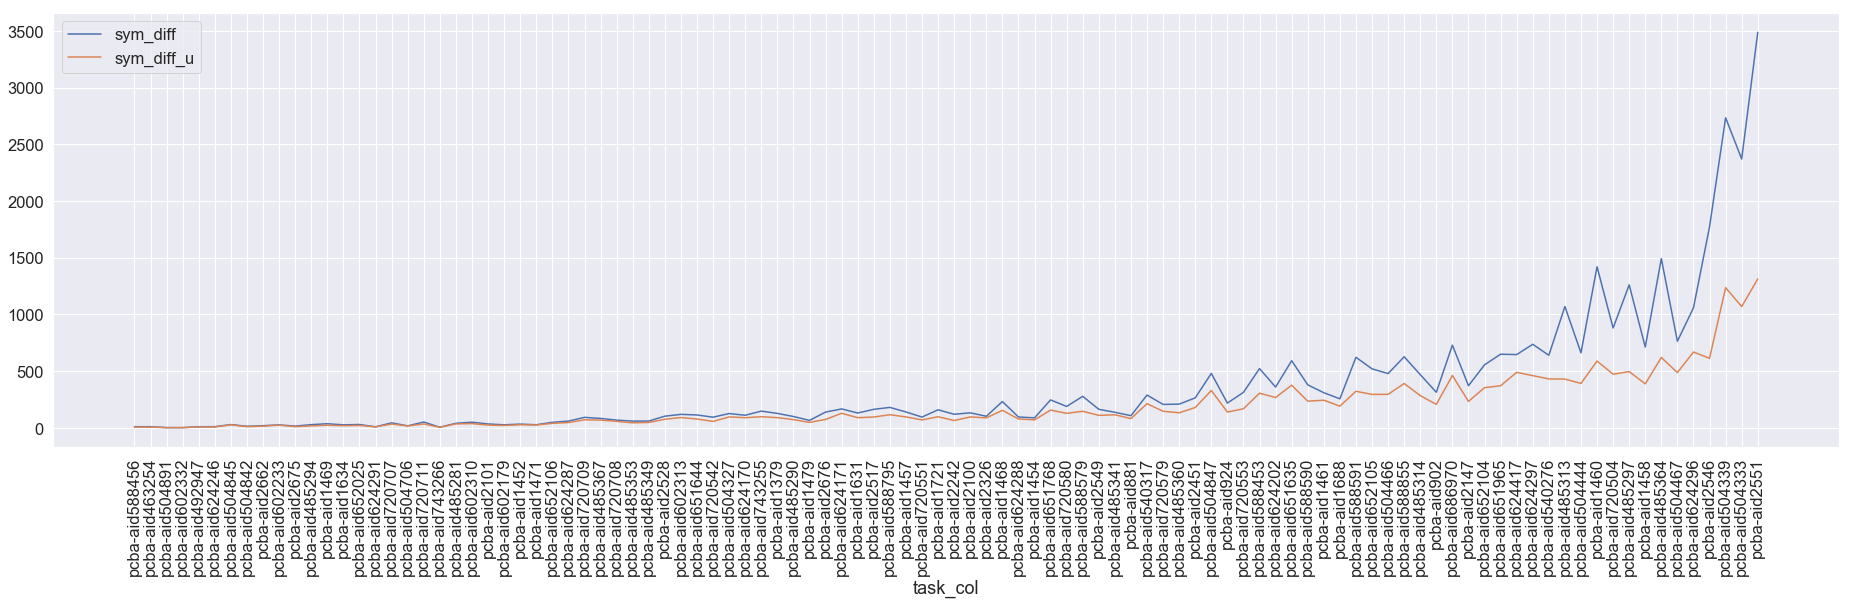

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=1.5)

figsize=(32, 8)
plt.figure(figsize=figsize)
sns.lineplot(x=task_means.index, y=task_means['sym_diff'].values, sort=False)
sns.lineplot(x=task_means.index, y=task_means['sym_diff_u'].values, sort=False)
plt.xticks(rotation=90);
plt.legend(['sym_diff', 'sym_diff_u'])

In [41]:
cols = ['609_hits', 'MABE_hits', 'union', 'sym_diff', 'disagree %', 'active_ratio'] 
tmp_df = task_means[cols]
tmp_df.columns = ['CBWS_609 Mean Total Hits', 'MABSel_exploitive Mean Total Hits', 
                  'Union Mean Total Hits', 'Symmatric Difference Mean Total Hits', 'Mean Disagreement Ratio', 'Hit %']
tmp_df

,CBWS_609 Mean Total Hits,MABSel_exploitive Mean Total Hits,Union Mean Total Hits,Symmatric Difference Mean Total Hits,Mean Disagreement Ratio,Hit %
task_col,,,,,,
pcba-aid588456,18.9,20.3,24.8,10.4,0.419355,0.01
pcba-aid463254,6.2,10.3,13.5,10.5,0.777778,0.01
pcba-aid504891,1.3,2.4,3.0,2.3,0.766667,0.01
pcba-aid602332,0.6,2.3,2.6,2.3,0.884615,0.02
pcba-aid492947,6.1,9.8,13.0,10.1,0.776923,0.02
pcba-aid624246,11.7,5.8,14.0,10.5,0.750000,0.03
pcba-aid504845,24.2,18.2,35.7,29.0,0.812325,0.03
pcba-aid504842,22.2,20.7,28.4,13.9,0.489437,0.03
pcba-aid2662,19.1,15.4,26.9,19.3,0.717472,0.04


In [ ]:
print(tmp_df.round(2).to_latex(longtable=True))

In [45]:
tmp_df[tmp_df['Mean Disagreement Ratio'] > 0.5]

,CBWS_609 Mean Total Hits,MABSel_exploitive Mean Total Hits,Union Mean Total Hits,Symmatric Difference Mean Total Hits,Mean Disagreement Ratio,Hit %
task_col,,,,,,
pcba-aid463254,6.2,10.3,13.5,10.5,0.777778,0.01
pcba-aid504891,1.3,2.4,3.0,2.3,0.766667,0.01
pcba-aid602332,0.6,2.3,2.6,2.3,0.884615,0.02
pcba-aid492947,6.1,9.8,13.0,10.1,0.776923,0.02
pcba-aid624246,11.7,5.8,14.0,10.5,0.750000,0.03
pcba-aid504845,24.2,18.2,35.7,29.0,0.812325,0.03
pcba-aid2662,19.1,15.4,26.9,19.3,0.717472,0.04
pcba-aid602233,32.1,37.4,47.9,26.3,0.549061,0.04
pcba-aid2675,21.0,10.0,23.3,15.6,0.669528,0.04
